In [1]:
import lyricsgenius as lg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spotipy
import time

from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

from spotipy.oauth2 import SpotifyClientCredentials
from requests.exceptions import Timeout



In [2]:
# artists = ['Logic', 'Rihanna', 'Frank Sinatra']


# def get_lyrics(arr, k):  # Write lyrics of k songs by each artist in arr
#     c = 0  # Counter
#     for name in arr:
#         try:
#             songs = (genius.search_artist(name, max_songs=k, sort='popularity')).songs
#             s = [song.lyrics for song in songs]
#             print("\n \n   <|endoftext|>   \n \n".join(s))  # Deliminator
#             c += 1
#             print(f"Songs grabbed:{len(s)}")
#         except:  #  Broad catch which will give us the name of artist and song that threw the exception
#             print(f"some exception at {name}: {c}")



In [3]:
all_top_songs = pd.read_excel('data/top_10000_songs_201129.xlsx', index_col=0) 

/Users/sam/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [4]:
year_dis_song = all_top_songs.groupby('Year')['Song'].count()

In [5]:
cur_songs_start = 5000
cur_songs_end = 6000
current_songs = all_top_songs[cur_songs_start:cur_songs_end]

In [6]:
current_songs

,PLACE,Artist,Song,Year,PLACE08,PLACE11,PLACE13,PLACE14,PLACE15,PLACE17,PLACE18
ID,,,,,,,,,,,
1847,5001,The Rolling Stones,Emotional Rescue,1980,2860.0,NaN,NaN,NaN,NaN,4154.0,4189.0
6293,5002,Erasure,A Little Respect,1988,NaN,NaN,NaN,4451.0,4839.0,4941.0,5026.0
13519,5003,"Jim Europe's 369th Infantry ""Hellfighters"" Band",Memphis Blues,1919,NaN,NaN,NaN,NaN,NaN,6579.0,6669.0
5404,5004,Belle and Sebastian,"Step into My Office, Baby",2003,NaN,NaN,NaN,5844.0,NaN,4578.0,4647.0
5999,5005,Death Cab for Cutie,Soul Meets Body,2005,NaN,NaN,NaN,2824.0,3451.0,4606.0,4715.0
...,...,...,...,...,...,...,...,...,...,...,...
16589,5996,Amen Dunes,Believe,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4541,5997,Badfinger,Without You,1970,NaN,NaN,2456.0,4295.0,NaN,6171.0,6235.0
6548,5998,Gerry and The Pacemakers,How Do You Do It?,1963,NaN,NaN,NaN,5331.0,3976.0,5981.0,6044.0


In [8]:
all_top_albums = pd.read_excel('data/top_3000_albums_201129.xls', index_col=0) 

In [9]:
year_dis_album = all_top_albums.groupby('Year')['Album'].count()

In [97]:

cur_album_start = 827
cur_album_end = 1500
current_albums = all_top_albums[cur_album_start:cur_album_end]

In [98]:
current_albums

,PLACE,Artist,Album,Year,PLACE08,PLACE09,PLACE10,PLACE13,PLACE14,PLACE15,PLACE17,PLACE18
i,,,,,,,,,,,,
268,828.0,T. Rex,The Slider,1972,695.0,769.0,812.0,789.0,859.0,740.0,765.0,751.0
2025,829.0,Weather Report,Heavy Weather,1977,773.0,787.0,878.0,763.0,908.0,887.0,864.0,863.0
982,830.0,2Pac,All Eyez on Me,1996,879.0,863.0,818.0,932.0,952.0,1012.0,965.0,990.0
1028,831.0,Pulp,This Is Hardcore,1998,659.0,702.0,730.0,804.0,794.0,867.0,750.0,732.0
5703,832.0,Bon Iver,"22, A Million",2016,NaN,NaN,NaN,NaN,NaN,NaN,592.0,638.0
...,...,...,...,...,...,...,...,...,...,...,...,...
204,1496.0,Rod Stewart,Gasoline Alley,1970,816.0,1009.0,1095.0,988.0,1172.0,1222.0,1333.0,1344.0
1612,1497.0,2Pac,Me Against the World,1995,1519.0,1669.0,1768.0,1628.0,1320.0,1537.0,1543.0,1544.0
2079,1498.0,Belle and Sebastian,The Life Pursuit,2006,1163.0,1503.0,961.0,1162.0,1068.0,1210.0,1394.0,1441.0


In [99]:
#Look at distribution of songs/albums over the years

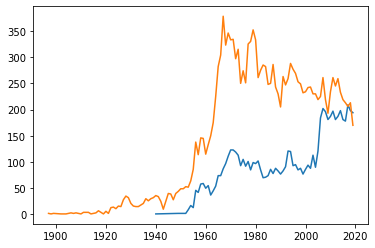

In [100]:
plt.plot(year_dis_album)
plt.plot(year_dis_song)
#orange = songs
#blue = albums

In [101]:
PARENT_GENRES = ["pop", 'rock', 'hip hop', 'latin', 'edm', 'r&b', 
                    'country', 'folk', 'classical', 'metal', 'jazz', 'easy listening', 'new age', 'blues', 'world']
    

In [102]:
def make_dictionaries(parent, fileName):
    assert parent in PARENT_GENRES, "The passed name should be a in PARENT_GENRES"
    
    return_dict = {}
        
    f = open(fileName, "r")
    for line in f:
        if line.strip() != "Explore" and line.strip() !="\n" and line.strip() != "":
      
            child_genre = line.strip().lower()
            return_dict[child_genre] = parent
       
            
    return return_dict

        

In [103]:
pop_dict = make_dictionaries("pop", "./data/pop_children.txt")
rock_dict = make_dictionaries("rock", "./data/rock_children.txt")
hip_hop_dict = make_dictionaries("hip hop", "./data/hip_hop_children.txt")
blues_dict = make_dictionaries("blues", "./data/blues_children.txt")
classical_dict = make_dictionaries("classical", "./data/classical_children.txt")
easy_listening_dict = make_dictionaries("easy listening", "./data/easy_listening_children.txt")
edm_dict = make_dictionaries("edm", "./data/edm_children.txt")
folk_dict = make_dictionaries("folk", "./data/folk_children.txt")
jazz_dict = make_dictionaries("jazz", "./data/jazz_children.txt")
latin_dict = make_dictionaries("latin", "./data/latin_children.txt")
metal_dict = make_dictionaries("metal", "./data/metal_children.txt")
new_age_dict = make_dictionaries("new age", "./data/new_age_children.txt")
r_n_b_dict = make_dictionaries("r&b", "./data/r&b_children.txt")
country_dict = make_dictionaries("country", "./data/country_children.txt")
world_dict = make_dictionaries("world", "./data/world_children.txt")

all_genres_dict = {**pop_dict,**rock_dict, **hip_hop_dict, **blues_dict, **classical_dict, 
                   **easy_listening_dict, **edm_dict, **folk_dict, **jazz_dict, **latin_dict,
                  **metal_dict, **new_age_dict, **r_n_b_dict, **country_dict, **world_dict}

In [104]:
def getArtistGenre(genres):
    '''
    This takes a list of possible genres for an artist from the spotify API
    ex. ['adult standards', 'brill building pop', 'easy listening', 'lounge']
    If a parent genre is in the list it will return that as the genre
    Otherwise it will loop through the genres, and analyze the children genres
    The majority parent genre of the children genre will determine the returned genre
    ex. if 5 of 7 genres parent genre is rock, rock will be returned
    '''
    PARENT_GENRES = ["pop", 'rock', 'hip hop', 'latin', 'edm', 'r&b', 
                    'country', 'folk', 'classical', 'metal', 'jazz', 'easy listening', 'new age', 'blues', 'world']
    
    returnGenre = ""
    
    #First check to see if a parent genre in list of spotify genres
    num_parents_in_genres = 0
    for g in genres:
        if g in PARENT_GENRES:
            returnGenre = g
            num_parents_in_genres+=1
            
    # Edge case two parent genres in a list (['dance pop', 'edm', 'pop', 'pop dance', 'pop rap'])
    # 1: count all of them and return the parent genre with most child genre
    
    if num_parents_in_genres == 1: #If only one parent genre included, return it
        return returnGenre
        
    #If a parent genre didn't show up OR more than one showed up count all genres
    genre_counts = {'pop':0, 
                    'rock':0, 
                    'hip hop':0, 
                    'latin': 0,
                    'edm': 0,
                    'r&b': 0,
                    'country': 0,
                    'folk': 0,
                    'classical': 0,
                    'metal': 0,
                    'jazz': 0,
                    'new age': 0,
                    'blues': 0,
                    'world': 0,
                    'easy listening': 0}
    
    
    for g in genres:
        try:
            parent = all_genres_dict[g]
            genre_counts[parent]+=1
        except:
            pass
        
    #TODO do we need to think about ties?
    max_genre = "no genre"
    max_genre_count = 0
    for p in PARENT_GENRES:
        if genre_counts[p] > max_genre_count:
            max_genre = p
            max_genre_count = genre_counts[p]
            
    returnGenre = max_genre
           
   
    return returnGenre
    
    

In [105]:
def getMostPopWord(lyrics):
    """
    Gets Called in count lyrics
    """

    text_tokens = word_tokenize(lyrics)
    lyrics_without_sw = [word for word in text_tokens if not word in stopwords.words()]
#     print(lyrics_without_sw)
    
    #I tried this. It seems to have some issues. For example, it converts 'us' to 'u'
    #This may not be the best option to get the most common words if the words aren't clearly recognizable
    
#     #Lemmatize the lyrics 
#     lmtzr = WordNetLemmatizer()
#     lem_lyrics = [[lmtzr.lemmatize(word) for word in word_tokenize(s)]
#               for s in lyrics_without_sw]
    
#     lem_lyrics_flat = []
#     for sublist in lem_lyrics:
#         lem_lyrics_flat.extend(sublist)
    
#     print(lem_lyrics_flat)
    
    c = Counter(lyrics_without_sw)
    return c.most_common(10)


def countLyrics(lyrics):
    """
    Takes in the output of 
    "\n \n   <|endoftext|>   \n \n".join([song.lyrics]))
    The first line is always the name of the song and the word lyrics
    There is always a number followed by embed on the last string
    Gets num lyrics, num unique lyrics, and specific word counts
    """
    
    #Remove the first line that has the title of the song and the word 'lyrics'
    split = lyrics.split("\n")
    del split[0]
    lyrics = "\n".join(split)
    
    pattern = r'\d*Embed'
    lyrics = re.sub(pattern, '', lyrics )
    
    pattern = r'You might also like'
    lyrics = re.sub(pattern, '', lyrics )

    
    #Convert to lower and remove non-alphnumeric chars
    lyrics = lyrics.lower()
    lyrics = re.sub(r'\W+', ' ', lyrics)   
    most_common_words = getMostPopWord(lyrics)
    
        
    #Parse most common words
    #get most common words (cw) and common word counts (cwc)
    try:
        cw1 = most_common_words[0][0]
        cw1c = most_common_words[0][1]
    except:
        cw1 = "NA"
        cw1c = 0
    
    try:
        cw2 = most_common_words[1][0]
        cw2c = most_common_words[1][1]
    except:
        cw2 = "NA"
        cw2c = 0
    
    try:
        cw3 = most_common_words[2][0]
        cw3c = most_common_words[2][1]
    except:
        cw3 = "NA"
        cw3c = 0
    
    try:
        cw4 = most_common_words[3][0]
        cw4c = most_common_words[3][1]
    except:
        cw4 = "NA"
        cw4c = 0
    
    try:
        cw5 = most_common_words[4][0]
        cw5c = most_common_words[4][1]
    except:
        cw5 = "NA"
        cw5c = 0
    
    try:
        cw6 = most_common_words[5][0]
        cw6c = most_common_words[5][1]
    except:
        cw6 = "NA"
        cw6c = 0
    
    try:
        cw7 = most_common_words[6][0]
        cw7c = most_common_words[6][1]
    except:
        cw7 = "NA"
        cw7c = 0
    
    try:
        cw8 = most_common_words[7][0]
        cw8c = most_common_words[7][1]
    except:
        cw8 = "NA"
        cw8c = 0
    
    try:
        cw9 = most_common_words[8][0]
        cw9c = most_common_words[8][1]
    except:
        cw9 = "NA"
        cw9c = 0
    
    try:
        cw10 = most_common_words[9][0]
        cw10c = most_common_words[9][1]
    except:
        cw10 = "NA"
        cw10c = 0
    

    #Count number of total lyrics and unique lyrics
    allWords = lyrics.split()
    num_unique = len(np.unique(allWords))
    total_words = len(allWords)
    

    #pattern matching
    
    #***************
    # LOVE
    #***************
    love_pattern = 'lov(e|ing|er|es|ely|ed)\\b'
    love_words = len(re.findall(love_pattern, lyrics))
    
    #***************
    # GOD
    #***************
    god_pattern = 'go(d|ds|ddes)\\b|jesus\\b|christ\\b'
    god_words = len(re.findall(god_pattern, lyrics))
    
    #***************
    # DANCE
    #***************
    dance_pattern = 'danc(e|es|ing|er)\\b'
    dance_words = len(re.findall(dance_pattern, lyrics))
    
    #***************
    # COOL
    #***************
    cool_pattern = 'coo(l|ler|lest)\\b'
    cool_words = len(re.findall(cool_pattern, lyrics))
    
    #***************
    # ROCK
    #***************
    rock_pattern = 'roc(k|ked|kers|ks|ker|king)\\b'
    rock_words = len(re.findall(rock_pattern, lyrics))
    
    #***************
    # SWEAR
    #***************
    swear_pattern = 'dam(n|ns|ned)\\b|fuc(k|ks|ked|ker|kers|king|kin)\\b|shi(t|ty|ts|ting|ter)\\b|hel(l|ls)\\b|bitc(h|hes|hen)\\b|bastar(d|ds)|as(s|es|shole|sholes)\\b'
    swear_words = len(re.findall(swear_pattern, lyrics))
    
    #***************
    # FAMILY
    #***************
    family_pattern = 'fa(m|mily|milies|)\\b|br(o|other|others)\\b|sis(ter|ters)\\b|so(n|ns)\\b|daugh(ter|ters)\\b|husban(d|ds)|wi(fe|ves)\\b|cousi(n|ns)\\b|uncl(e|es)\\b|aun(t|ts|ties)\\b'
    family_words = len(re.findall(family_pattern, lyrics))
    
    #***************
    # BABY
    #***************
    baby_pattern = 'ba(e|be|by|bies)\\b'
    baby_words = len(re.findall(baby_pattern, lyrics))
 

    #***************
    # MONEY
    #***************
    money_pattern = 'money\\b|cash\\b|doll(er|ers|a|az)\\b|buc(k|ks)\\b|coi(n|ns)\\b|bil(l|ls|lz)\\b'
    money_words = len(re.findall(money_pattern, lyrics))
    
    #***************
    # FUNKY
    #***************
    funky_pattern = 'fun(k|ky)\\b'
    funky_words = len(re.findall(funky_pattern, lyrics))
    
    #***************
    # CHILL
    #***************
    chill_pattern = 'chil(l|ls)\\b'
    chill_words = len(re.findall(chill_pattern, lyrics))
    
    
    
    
    
    return num_unique,total_words,love_words,god_words,dance_words,cool_words,rock_words,swear_words,family_words,baby_words,money_words,funky_words,chill_words,cw1,cw1c,cw2,cw2c,cw3,cw3c,cw4,cw4c,cw5,cw5c,cw6,cw6c,cw7,cw7c,cw8,cw8c,cw9,cw9c,cw10,cw10c
    
    
    

In [106]:
#Set up genius API
genius = lg.Genius('cPaJbcaz-llZE_G6jO_bHtcPFyJps_aiwumM5pF_xoPIBkmXHifU6lhHcOcbwOlY',  # Client access token from Genius Client API page
                             skip_non_songs=True, excluded_terms=["(Remix)", "(Live)"],
                             remove_section_headers=True, verbose = True,
                             timeout=15, sleep_time=5, retries = 2)

# genius.sleep_time = 45


In [107]:
#Set up spotify API
cid = '2d2d4ac665f543db93244d6799fc01bc'
secret = '43cd8ad30758405fa3291b1b45e944fd'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [108]:
album_num=0
csv_name = "albums_"+str(cur_album_start)+ "_"+ str(cur_album_end)+ ".csv"
csv_fail_name = "albums_"+str(cur_album_start)+ "_"+ str(cur_album_end)+ "_fail.csv"

#csv of failed songs
l = open("./input_data/"+csv_fail_name, "w+")
header = "album|track|artist|year|id|reasonFail\n"
l.write(header)

#csv of completed songs
f = open("./input_data/"+csv_name, "w+")
header = "song|artist|year|genre|numUnique|totalWords|love_words|god_words|dance_words|cool_words|rock_words|swear_words|family_words|baby_words|money_words|funky_words|chill_words|cw1|cwc1|cw2|cwc2|cw3|cwc3|cw4|cwc4|cw5|cwc5|cw6|cwc6|cw7|cwc7|cw8|cwc8|cw9|cwc9|cw10|cwc10\n"
f.write(header)

#Write a row for each song 
for index, row in current_albums.iterrows():
    
    album_num+=1
    print("______________\n")
    cur_artist = row['Artist']
    cur_album = row['Album']
    cur_year = row['Year']
    cur_row = row['PLACE']
    cur_id = index
    print(f"Row: {cur_row}\nAlbum: {cur_album}\nArtist: {cur_artist}\n______________")


    
    #Genius api
    #Get num word, num unique, specific word counts etc.
    retries = 0
    while retries < 3:
        try:
            
            
            #Use genius API 
            print(f"Getting album. Attempt number {retries}")
            album = genius.search_album(cur_album, cur_artist)
            print("Got album")
        
            #Spotify api
            #Get Genre
            print(f"Getting genre list. Attempt number {retries}")
            results = sp.search(q=cur_artist, type='artist')
            items = results['artists']['items']
            print("Got genre list")
            
            if len(items) > 0:
                cur_artist_genre = getArtistGenre(items[0]['genres'])
            else:
                cur_artist_genre = "no genre"
                
            print(f"Got parent genre: {cur_artist_genre}")
            track = 0
            print("Looping tracks")
            for i in album.tracks:
                track +=1
                cur_lyrics = i.song.lyrics
                
                if len(cur_lyrics.split()) > 15:                    
                    num_unique,total_words,love_words,god_words,dance_words,cool_words,rock_words, swear_words,family_words,baby_words,money_words,funky_words,chill_words,cw1,cw1c,cw2,cw2c,cw3,cw3c,cw4,cw4c,cw5,cw5c,cw6,cw6c,cw7,cw7c,cw8,cw8c,cw9,cw9c,cw10,cw10c= countLyrics(cur_lyrics)
                    #If everything works. Write the line to the file
                    line = f"{cur_album}|{cur_artist}|{cur_year}|{cur_artist_genre}|{num_unique}|{total_words}|{love_words}|{god_words}|{dance_words}|{cool_words}|{rock_words}|{swear_words}|{family_words}|{baby_words}|{money_words}|{funky_words}|{chill_words}|{cw1}|{cw1c}|{cw2}|{cw2c}|{cw3}|{cw3c}|{cw4}|{cw4c}|{cw5}|{cw5c}|{cw6}|{cw6c}|{cw7}|{cw7c}|{cw8}|{cw8c}|{cw9}|{cw9c}|{cw10}|{cw10c}\n"
                    f.write(line)
                    
                else:
                    line = f"{cur_album}|{track}|{cur_artist}|{cur_year}|{cur_id}|too_few_lyrics\n"
                    l.write(line)
                    

        except Timeout as e:
            print(retries)
            retries += 1
            continue
            
        except ConnectionError as cr:
            line = f"{cur_album}|{0}|{cur_artist}|{cur_year}|{cur_id}|time_out\n"
            l.write(line)
            
        except AssertionError as ae: #If we can't find the song, keep track of that song/artist/id
            line = f"{cur_album}|{0}|{cur_artist}|{cur_year}|{cur_id}|not_found\n"
            l.write(line)
            
        except AttributeError as ae: #If we can't find the song, keep track of that song/artist/id
            line = f"{cur_album}|{0}|{cur_artist}|{cur_year}|{cur_id}|not_found\n"
            l.write(line)
            
            
            
        
            


            
        break
        
    if retries >= 3: #If we time out 3 times, keep track and move on
        line = f"{cur_album}|{track}|{cur_artist}|{cur_year}|{cur_id}|time_out\n"
        l.write(line)
        
f.close()
l.close()



______________

Row: 828.0
Album: The Slider
Artist: T. Rex
______________
Getting album. Attempt number 0
Searching for "The Slider" by T. Rex...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 829.0
Album: Heavy Weather
Artist: Weather Report
______________
Getting album. Attempt number 0
Searching for "Heavy Weather" by Weather Report...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: jazz
Looping tracks
______________

Row: 830.0
Album: All Eyez on Me
Artist: 2Pac
______________
Getting album. Attempt number 0
Searching for "All Eyez on Me" by 2Pac...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: hip hop
Looping tracks
______________

Row: 831.0
Album: This Is Hardcore
Artist: Pulp
______________
Getting album. Attempt number 0
Searching for "This Is Hardcore" by Pulp...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent ge

______________

Row: 859.0
Album: The Warning
Artist: Hot Chip
______________
Getting album. Attempt number 0
Searching for "The Warning" by Hot Chip...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 860.0
Album: The Sidewinder
Artist: Lee Morgan
______________
Getting album. Attempt number 0
Searching for "The Sidewinder" by Lee Morgan...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: jazz
Looping tracks
______________

Row: 861.0
Album: Eli and the Thirteenth Confession
Artist: Laura Nyro
______________
Getting album. Attempt number 0
Searching for "Eli and the Thirteenth Confession" by Laura Nyro...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: folk
Looping tracks
______________

Row: 862.0
Album: Fire of Love
Artist: The Gun Club
______________
Getting album. Attempt number 0
Searching for "Fire of Love" by The Gun Club...
Got album
Getting ge

______________

Row: 889.0
Album: Song for My Father
Artist: Horace Silver
______________
Getting album. Attempt number 0
Searching for "Song for My Father" by Horace Silver...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: jazz
Looping tracks
______________

Row: 890.0
Album: Green
Artist: R.E.M.
______________
Getting album. Attempt number 0
Searching for "Green" by R.E.M....
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 891.0
Album: Bloom
Artist: Beach House
______________
Getting album. Attempt number 0
Searching for "Bloom" by Beach House...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 892.0
Album: Foo Fighters
Artist: Foo Fighters
______________
Getting album. Attempt number 0
Searching for "Foo Fighters" by Foo Fighters...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent gen

Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 920.0
Album: Young Americans
Artist: David Bowie
______________
Getting album. Attempt number 0
Searching for "Young Americans" by David Bowie...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 921.0
Album: Songs from a Room
Artist: Leonard Cohen
______________
Getting album. Attempt number 0
Searching for "Songs from a Room" by Leonard Cohen...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: folk
Looping tracks
______________

Row: 922.0
Album: Use Your Illusion I
Artist: Guns N' Roses
______________
Getting album. Attempt number 0
Searching for "Use Your Illusion I" by Guns N' Roses...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 923.0
Album: Our Love
Artist: Caribou
______________
Getti

______________

Row: 949.0
Album: Rounds
Artist: Four Tet
______________
Getting album. Attempt number 0
Searching for "Rounds" by Four Tet...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: new age
Looping tracks
______________

Row: 950.0
Album: Saint Dominic's Preview
Artist: Van Morrison
______________
Getting album. Attempt number 0
Searching for "Saint Dominic's Preview" by Van Morrison...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: folk
Looping tracks
______________

Row: 951.0
Album: Dixie Chicken
Artist: Little Feat
______________
Getting album. Attempt number 0
Searching for "Dixie Chicken" by Little Feat...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 952.0
Album: Drums and Wires
Artist: XTC
______________
Getting album. Attempt number 0
Searching for "Drums and Wires" by XTC...
Got album
Getting genre list. Attempt number 0
Got genr

______________

Row: 979.0
Album: L'Etat Et Moi
Artist: Blumfeld
______________
Getting album. Attempt number 0
Searching for "L'Etat Et Moi" by Blumfeld...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: pop
Looping tracks
______________

Row: 980.0
Album: Monarchie und Alltag
Artist: Fehlfarben
______________
Getting album. Attempt number 0
Searching for "Monarchie und Alltag" by Fehlfarben...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 981.0
Album: Coloring Book
Artist: Chance the Rapper
______________
Getting album. Attempt number 0
Searching for "Coloring Book" by Chance the Rapper...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: hip hop
Looping tracks
______________

Row: 982.0
Album: Presenting the Fabulous Ronettes featuring Veronica
Artist: The Ronettes
______________
Getting album. Attempt number 0
Searching for "Presenting the Fabulou

Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: hip hop
Looping tracks
______________

Row: 1009.0
Album: The Battle of Los Angeles
Artist: Rage Against the Machine
______________
Getting album. Attempt number 0
Searching for "The Battle of Los Angeles" by Rage Against the Machine...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1010.0
Album: Dub Housing
Artist: Pere Ubu
______________
Getting album. Attempt number 0
Searching for "Dub Housing" by Pere Ubu...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1011.0
Album: My Life
Artist: Mary J. Blige
______________
Getting album. Attempt number 0
Searching for "My Life" by Mary J. Blige...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: r&b
Looping tracks
______________

Row: 1012.0
Album: The Southern Harmony and Musical Compan

Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: jazz
Looping tracks
______________

Row: 1039.0
Album: From a Basement on the Hill
Artist: Elliott Smith
______________
Getting album. Attempt number 0
Searching for "From a Basement on the Hill" by Elliott Smith...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1040.0
Album: Hoodoo Man Blues
Artist: Junior Wells' Chicago Blues Band
______________
Getting album. Attempt number 0
Searching for "Hoodoo Man Blues" by Junior Wells' Chicago Blues Band...
No results found for: 'Hoodoo Man Blues Junior Wells' Chicago Blues Band'
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: blues
Looping tracks
______________

Row: 1041.0
Album: How Will the Wolf Survive?
Artist: Los Lobos
______________
Getting album. Attempt number 0
Searching for "How Will the Wolf Survive?" by Los Lobos...
Got album
Getting genre list. A

Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: country
Looping tracks
______________

Row: 1067.0
Album: Helplessness Blues
Artist: Fleet Foxes
______________
Getting album. Attempt number 0
Searching for "Helplessness Blues" by Fleet Foxes...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: folk
Looping tracks
______________

Row: 1068.0
Album: Ride the Lightning
Artist: Metallica
______________
Getting album. Attempt number 0
Searching for "Ride the Lightning" by Metallica...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: metal
Looping tracks
______________

Row: 1069.0
Album: Mermaid Avenue
Artist: Billy Bragg & Wilco
______________
Getting album. Attempt number 0
Searching for "Mermaid Avenue" by Billy Bragg & Wilco...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: folk
Looping tracks
______________

Row: 1070.0
Album: High Land, Hard Rain
Artist: Aztec 

Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1097.0
Album: Heliocentric Worlds of Sun Ra
Artist: Sun Ra
______________
Getting album. Attempt number 0
Searching for "Heliocentric Worlds of Sun Ra" by Sun Ra...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: jazz
Looping tracks
______________

Row: 1098.0
Album: Wrecking Ball
Artist: Emmylou Harris
______________
Getting album. Attempt number 0
Searching for "Wrecking Ball" by Emmylou Harris...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: folk
Looping tracks
______________

Row: 1099.0
Album: Chill Out
Artist: The KLF
______________
Getting album. Attempt number 0
Searching for "Chill Out" by The KLF...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: pop
Looping tracks
______________

Row: 1100.0
Album: It's So Hard to Tell Who's Going to Love You the Best
Artist: 

______________

Row: 1126.0
Album: Puta's Fever
Artist: Mano Negra
______________
Getting album. Attempt number 0
Searching for "Puta's Fever" by Mano Negra...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1127.0
Album: It's a Shame About Ray
Artist: The Lemonheads
______________
Getting album. Attempt number 0
Searching for "It's a Shame About Ray" by The Lemonheads...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1128.0
Album: The Velvet Rope
Artist: Janet Jackson
______________
Getting album. Attempt number 0
Searching for "The Velvet Rope" by Janet Jackson...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: r&b
Looping tracks
______________

Row: 1129.0
Album: Trompe le Monde
Artist: Pixies
______________
Getting album. Attempt number 0
Searching for "Trompe le Monde" by Pixies...
Got album
Getting genre

Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1156.0
Album: In Search of...
Artist: N.E.R.D.
______________
Getting album. Attempt number 0
Searching for "In Search of..." by N.E.R.D....
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: hip hop
Looping tracks
______________

Row: 1157.0
Album: Viva La Vida or Death and All His Friends
Artist: Coldplay
______________
Getting album. Attempt number 0
Searching for "Viva La Vida or Death and All His Friends" by Coldplay...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: pop
Looping tracks
______________

Row: 1158.0
Album: Heaven Up Here
Artist: Echo and the Bunnymen
______________
Getting album. Attempt number 0
Searching for "Heaven Up Here" by Echo and the Bunnymen...
No results found for: 'Heaven Up Here Echo and the Bunnymen'
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent ge

______________

Row: 1185.0
Album: Vincebus Eruptum
Artist: Blue Cheer
______________
Getting album. Attempt number 0
Searching for "Vincebus Eruptum" by Blue Cheer...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1186.0
Album: Grand Prix
Artist: Teenage Fanclub
______________
Getting album. Attempt number 0
Searching for "Grand Prix" by Teenage Fanclub...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1187.0
Album: Talking with the Taxman About Poetry
Artist: Billy Bragg
______________
Getting album. Attempt number 0
Searching for "Talking with the Taxman About Poetry" by Billy Bragg...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: folk
Looping tracks
______________

Row: 1188.0
Album: Soul Mining
Artist: The The
______________
Getting album. Attempt number 0
Searching for "Soul Mining" by The The...
Got 

______________

Row: 1215.0
Album: More Specials
Artist: The Specials
______________
Getting album. Attempt number 0
Searching for "More Specials" by The Specials...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1216.0
Album: Blondie
Artist: Blondie
______________
Getting album. Attempt number 0
Searching for "Blondie" by Blondie...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1217.0
Album: The Drift
Artist: Scott Walker
______________
Getting album. Attempt number 0
Searching for "The Drift" by Scott Walker...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1218.0
Album: Double Fantasy
Artist: John Lennon & Yoko Ono
______________
Getting album. Attempt number 0
Searching for "Double Fantasy" by John Lennon & Yoko Ono...
Got album
Getting genre list. Attempt number

______________

Row: 1245.0
Album: Dig!!! Lazarus Dig!!!
Artist: Nick Cave & The Bad Seeds
______________
Getting album. Attempt number 0
Searching for "Dig!!! Lazarus Dig!!!" by Nick Cave & The Bad Seeds...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1246.0
Album: The Perfect Prescription
Artist: Spacemen 3
______________
Getting album. Attempt number 0
Searching for "The Perfect Prescription" by Spacemen 3...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1247.0
Album: The Hour of Bewilderbeast
Artist: Badly Drawn Boy
______________
Getting album. Attempt number 0
Searching for "The Hour of Bewilderbeast" by Badly Drawn Boy...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: pop
Looping tracks
______________

Row: 1248.0
Album: ...And Justice for All
Artist: Metallica
______________
Getting album. Attempt

Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1274.0
Album: Basket of Light
Artist: The Pentangle
______________
Getting album. Attempt number 0
Searching for "Basket of Light" by The Pentangle...
No results found for: 'Basket of Light The Pentangle'
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: folk
Looping tracks
______________

Row: 1275.0
Album: Psalm 69: The Way to Succeed & the Way to Suck Eggs
Artist: Ministry
______________
Getting album. Attempt number 0
Searching for "Psalm 69: The Way to Succeed & the Way to Suck Eggs" by Ministry...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1276.0
Album: The Paul Butterfield Blues Band
Artist: The Paul Butterfield Blues Band
______________
Getting album. Attempt number 0
Searching for "The Paul Butterfield Blues Band" by The Paul Butterfield Blues Band...


Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1303.0
Album: In C
Artist: Terry Riley
______________
Getting album. Attempt number 0
Searching for "In C" by Terry Riley...
No results found for: 'In C Terry Riley'
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: classical
Looping tracks
______________

Row: 1304.0
Album: Zuma
Artist: Neil Young
______________
Getting album. Attempt number 0
Searching for "Zuma" by Neil Young...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1305.0
Album: The Dreaming
Artist: Kate Bush
______________
Getting album. Attempt number 0
Searching for "The Dreaming" by Kate Bush...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: pop
Looping tracks
______________

Row: 1306.0
Album: Santana
Artist: Santana
______________
Getting album. Attempt number 0
S

______________

Row: 1333.0
Album: Birds of Fire
Artist: Mahavishnu Orchestra
______________
Getting album. Attempt number 0
Searching for "Birds of Fire" by Mahavishnu Orchestra...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1334.0
Album: Innovator: Soundtrack for the Tenth Planet / Innovator [1997]
Artist: Derrick May
______________
Getting album. Attempt number 0
Searching for "Innovator: Soundtrack for the Tenth Planet / Innovator [1997]" by Derrick May...
No results found for: 'Innovator: Soundtrack for the Tenth Planet / Innovator [1997] Derrick May'
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: hip hop
Looping tracks
______________

Row: 1335.0
Album: Too-Rye-Ay
Artist: Dexys Midnight Runners
______________
Getting album. Attempt number 0
Searching for "Too-Rye-Ay" by Dexys Midnight Runners...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genr

Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: latin
Looping tracks
______________

Row: 1363.0
Album: Uncle Meat
Artist: Frank Zappa
______________
Getting album. Attempt number 0
Searching for "Uncle Meat" by Frank Zappa...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1364.0
Album: New Adventures in Hi-Fi
Artist: R.E.M.
______________
Getting album. Attempt number 0
Searching for "New Adventures in Hi-Fi" by R.E.M....
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1365.0
Album: Blue Valentine
Artist: Tom Waits
______________
Getting album. Attempt number 0
Searching for "Blue Valentine" by Tom Waits...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: folk
Looping tracks
______________

Row: 1366.0
Album: Tin Drum
Artist: Japan
______________
Getting album. Attempt number 0


Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: world
Looping tracks
______________

Row: 1393.0
Album: Sublime
Artist: Sublime
______________
Getting album. Attempt number 0
Searching for "Sublime" by Sublime...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: latin
Looping tracks
______________

Row: 1394.0
Album: La Superbe
Artist: Benjamin Biolay
______________
Getting album. Attempt number 0
Searching for "La Superbe" by Benjamin Biolay...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: pop
Looping tracks
______________

Row: 1395.0
Album: Antics
Artist: Interpol
______________
Getting album. Attempt number 0
Searching for "Antics" by Interpol...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1396.0
Album: The Marble Index
Artist: Nico
______________
Getting album. Attempt number 0
Searching for "The Marble Index" 

Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: hip hop
Looping tracks
______________

Row: 1423.0
Album: Album
Artist: Girls
______________
Getting album. Attempt number 0
Searching for "Album" by Girls...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: pop
Looping tracks
______________

Row: 1424.0
Album: The Fragile
Artist: Nine Inch Nails
______________
Getting album. Attempt number 0
Searching for "The Fragile" by Nine Inch Nails...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1425.0
Album: There Is No-One What Will Take Care of You
Artist: Palace Brothers
______________
Getting album. Attempt number 0
Searching for "There Is No-One What Will Take Care of You" by Palace Brothers...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: country
Looping tracks
______________

Row: 1426.0
Album: Little Criminals
Artist: R

No results found for: 'Trust Elvis Costello and The Attractions'
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1452.0
Album: For the Roses
Artist: Joni Mitchell
______________
Getting album. Attempt number 0
Searching for "For the Roses" by Joni Mitchell...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: folk
Looping tracks
______________

Row: 1453.0
Album: Fly Like an Eagle
Artist: Steve Miller Band
______________
Getting album. Attempt number 0
Searching for "Fly Like an Eagle" by Steve Miller Band...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1454.0
Album: Buscando América
Artist: Rubén Blades
______________
Getting album. Attempt number 0
Searching for "Buscando América" by Rubén Blades...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: latin
Looping tracks
__________

No results found for: 'Sleeps with Angels Neil Young and Crazy Horse'
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1482.0
Album: Harvest Moon
Artist: Neil Young
______________
Getting album. Attempt number 0
Searching for "Harvest Moon" by Neil Young...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1483.0
Album: Secrets of the Beehive
Artist: David Sylvian
______________
Getting album. Attempt number 0
Searching for "Secrets of the Beehive" by David Sylvian...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

Row: 1484.0
Album: In On the Kill Taker
Artist: Fugazi
______________
Getting album. Attempt number 0
Searching for "In On the Kill Taker" by Fugazi...
Got album
Getting genre list. Attempt number 0
Got genre list
Got parent genre: rock
Looping tracks
______________

